## Notebook Imports

In [1]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

## Download Resources

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eduardo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eduardo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Eduardo\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\Eduardo\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Constants

In [5]:
EXAMPLE_FILE = 'SpamData/Processing/practice_email.txt'

DATA_JSON_FILE = 'SpamData/Processing/clean-email-collection.json'
WORD_ID_FILE = 'SpamData/Processing/word-by-id.csv'
TRAINING_FILE = 'SpamData/Training/training-data.txt'
TESTING_FILE = 'SpamData/Training/testing-data.txt'

SPAM_1_PATH = 'SpamData/Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/Processing/spam_assassin_corpus/easy_ham_2'

NONSPAM_CATEGORY = 0
SPAM_CATEGORY = 1
VOCABULARY_START = 0
VOCABULARY_LIMIT = 2500
SPARSE_COLUMNS = ['DOC_ID', 'WORD_ID', 'LABEL']

CUSTOM_COLOR1 = ['#55efc4', '#ffeaa7']
CUSTOM_COLOR2 = ['#a29bfe', '#ff7675']


CLOUD_SHAPE = 'SpamData/Processing/wordcloud_resources/cloud.png'
THUMBS_UP_SHAPE = 'SpamData/Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_SHAPE = 'SpamData/Processing/wordcloud_resources/thumbs-down.png'

# Pre-Work
## File Reading Example 1:
### This will read the whole file without doing anything to it.

In [6]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

# File Reading Example 2:
### This will read the whole file and extract the body of the message, it will be used in the implementation later on.

In [7]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()
email_body = '\n'.join(lines)
print(email_body)





Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Phase 1: Gather Data

## Generator for email body extraction

In [8]:
def email_body_generator(emailPath):
    for root, directoryNames, fileNames in walk(emailPath):
        for file_name in fileNames:
            filepath = join(root, file_name)
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()
            email_body = '\n'.join(lines)
            yield file_name, email_body

In [9]:
def execute_from_dir(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
    
    # Create a pandas data frame with the results.
    return pd.DataFrame(rows, index=row_names)

In [10]:
spam_emails = execute_from_dir(SPAM_1_PATH, SPAM_CATEGORY)
spam_emails = spam_emails.append(execute_from_dir(SPAM_2_PATH, SPAM_CATEGORY))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [11]:
spam_emails.shape

(1898, 2)

In [12]:
nonspam_emails = execute_from_dir(EASY_NONSPAM_1_PATH, NONSPAM_CATEGORY)
nonspam_emails = nonspam_emails.append(execute_from_dir(EASY_NONSPAM_2_PATH, NONSPAM_CATEGORY))
nonspam_emails.shape

(3901, 2)

In [13]:
email_collection = pd.concat([spam_emails, nonspam_emails])
print('Full Email Collection: ', email_collection.shape)

Full Email Collection:  (5799, 2)


# Phase 2: Data Cleaning

### Check for missing values

In [14]:
# look for any messages where the body is null.
email_collection.MESSAGE.isnull().values.any() # There are not null emails

False

In [15]:
# look for any messages where the body is empty.
contain_empty = (email_collection.MESSAGE.str.len() == 0).any() # There are empty emails
countEmpty = 0

if contain_empty:
    countEmpty = (email_collection.MESSAGE.str.len() == 0).sum() # Count how many emails are empty

print('Empty emails = ', contain_empty)
print('Count of empty emails = ', countEmpty)

Empty emails =  True
Count of empty emails =  3


### Find location of the empty emails

In [16]:
 email_collection[email_collection.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [17]:
# Remove the empty emails

email_collection.drop('cmds', inplace=True)

In [18]:
email_collection.shape

(5796, 2)

In [19]:
email_collection[4608:4611]

,MESSAGE,CATEGORY
00213.8b921d7940c5b2ac05892b648bd77231,I will be out of the office starting 02/08/20...,0
00214.4a5f7fc36eda589a5716dd090c67e90a,\n\n<rant>\n\nI swear to god you have to be so...,0
00215.676fa487d6122e4a57b37a5edffa4dc2,>> I swear to god you have to be so carefull w...,0


### Replace index for Doc Ids to track emails in Dataset

In [20]:
# Create range of ids
docIds = range(0, len(email_collection.index))

# Assign the ids to the dataframe as a new column.
email_collection['DOC_ID'] = docIds

# Assign filenames to a new column.
email_collection['FILE_NAME'] = email_collection.index

email_collection.set_index('DOC_ID', inplace=True)

# Check how the change looks like
email_collection.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


### Save the work in Json format using Pandas

In [21]:
email_collection.to_json(DATA_JSON_FILE)

# Phase 3: Exploration & Data Visualization

### Identify the number of spam and non-spam currently in the DataSet.

In [22]:
email_collection.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [23]:
spam_count = email_collection.CATEGORY.value_counts()[1]
non_spam_count = email_collection.CATEGORY.value_counts()[0]

### Visualization

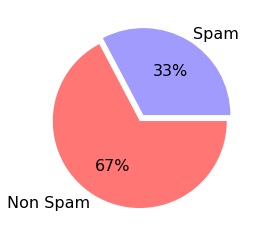

In [24]:
category_names = ['Spam', 'Non Spam']
sizes = [spam_count, non_spam_count]

# Depending the monitor where this chart is displayed, you might need to play around with 'plt.figure' below
# Example:
# plt.figure(figsize=(2,2), dpi=227)

plt.pie(sizes, labels=category_names, textprops={'fontsize': 16}, autopct='%1.0f%%', colors=CUSTOM_COLOR2, explode=[0,0.08])
plt.show()

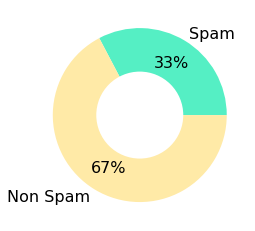

In [25]:
category_names = ['Spam', 'Non Spam']
sizes = [spam_count, non_spam_count]

# Depending the monitor where this chart is displayed, you might need to play around with 'plt.figure' below
# Example:
# plt.figure(figsize=(2,2), dpi=227)

plt.pie(sizes, labels=category_names, textprops={'fontsize': 16}, autopct='%1.0f%%', colors=CUSTOM_COLOR1, pctdistance=0.7)

center_circle = plt.Circle((0,0), radius=0.5, fc='white')
plt.gca().add_artist(center_circle)

plt.show()

# Natural Language Processing (NLP)

## Text Pre-Processing

In [26]:
def pre_process_email(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words('english'))):
    filtered_words = []
    
    # Remove html tags
    soup = BeautifulSoup(message, 'html.parser')
    msg_no_html= soup.get_text()
    
    
    # convert to lower case and tokenize
    words = word_tokenize(msg_no_html.lower())
    for word in words:
        # Removing Stopwords and add Word Stemming
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    
    return filtered_words

In [27]:
# Testing the pre_process_email function with a example message.
pre_process_email(email_collection.at[3, 'MESSAGE'])

['adult',
 'club',
 'offer',
 'free',
 'membership',
 'instant',
 'access',
 'site',
 'user',
 'name',
 'password',
 'user',
 'name',
 'zzzz',
 'password',
 'best',
 'adult',
 'site',
 'internet',
 'free',
 'news',
 'million',
 'member',
 'sign',
 'free',
 'last',
 'month',
 'new',
 'member',
 'one',
 'yet',
 'membership',
 'faq',
 'offer',
 'free',
 'access',
 'adult',
 'membership',
 'site',
 'free',
 'advertis',
 'pay',
 'ad',
 'space',
 'pay',
 'membership',
 'true',
 'membership',
 'life',
 'absolut',
 'never',
 'pay',
 'cent',
 'advertis',
 'give',
 'account',
 'friend',
 'famili',
 'ye',
 'long',
 'age',
 'sign',
 'membership',
 'site',
 'one',
 'get',
 'access',
 'get',
 'start',
 'click',
 'one',
 'follow',
 'link',
 'becom',
 'member',
 'multi',
 'million',
 'dollar',
 'oper',
 'polici',
 'rule',
 'fill',
 'requir',
 'info',
 'wo',
 'charg',
 'free',
 'pass',
 'believ',
 'us',
 'read',
 'term',
 'condit',
 'adult',
 'farm',
 'http',
 'girl',
 'anim',
 'get',
 'freaki',
 'life

### Slicing Dataframes and more...

In [28]:
# try our function with a small subset of the emails in the dataset
small_email_subset = email_collection.MESSAGE.iloc[0:3]

nested_list = small_email_subset.apply(pre_process_email)
print(nested_list)

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
Name: MESSAGE, dtype: object


In [29]:
%%time
# Above it check how long does it takes to pre-process the entire collection

# Apply our pre-processing fuction to the whole dataframe (nested list)
processed_emails = email_collection.MESSAGE.apply(pre_process_email)

C:\Users\Eduardo\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Wall time: 35.6 s


### Do further analysis to the processed emails

In [30]:
# get the ids for non-spams
doc_ids_non_spam = email_collection[email_collection.CATEGORY == NONSPAM_CATEGORY].index

# Get list of non-spam based on ids

nested_non_spam_list = processed_emails.loc[doc_ids_non_spam]

flat_list_non_spam = [item for sublist in nested_non_spam_list for item in sublist]

# Create Series of legit words
legit_words = pd.Series(flat_list_non_spam).value_counts()

In [31]:
# get the ids for spams
doc_ids_spam = email_collection[email_collection.CATEGORY == SPAM_CATEGORY].index

# Get list of spams based on ids
nested_spam_list = processed_emails.loc[doc_ids_spam]

flat_list_spam = [item for sublist in nested_spam_list for item in sublist]

# Create Series of spam words
spam_words = pd.Series(flat_list_spam).value_counts()

# Total number of unique words in the spam messages
spam_words.shape[0]

# Find the top 10 most common words used for spam.
spam_words[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

# Data Visualization part 2 

### Examples  of how to use WordCloud to present data

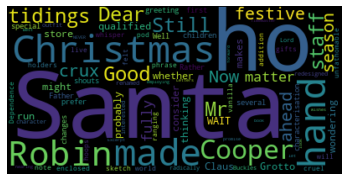

In [32]:
# Example 1 - Very simple example, call the generate wordcloud function passing a basic text,
# then using plt to generate the image.

word_cloud_1 = WordCloud().generate(email_body)
plt.imshow(word_cloud_1, interpolation='bilinear')
plt.axis('off')
plt.show()

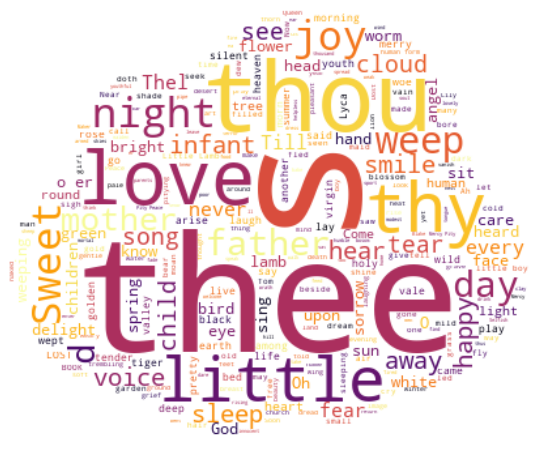

In [33]:
# Example 2 - Using a package from nltk to retrieve novels and use them for a more complete example.
icon = Image.open(CLOUD_SHAPE)
image_canvas = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_canvas.paste(icon, box=icon)

rgb_array = np.array(image_canvas)

example_corpus = nltk.corpus.gutenberg.words('blake-poems.txt')

# Example corpus will have a different type and we need to convert it to a readable String.
ready_string = ' '.join([''.join(word) for word in example_corpus])

word_cloud_2 = WordCloud(mask=rgb_array,background_color='white',colormap='inferno',max_words=500)

word_cloud_2.generate(ready_string)
plt.figure(figsize=[16,8])
plt.imshow(word_cloud_2, interpolation='bilinear')
plt.axis('off')
plt.show()

### Use wordcloud to Present spam and non-spam Messages

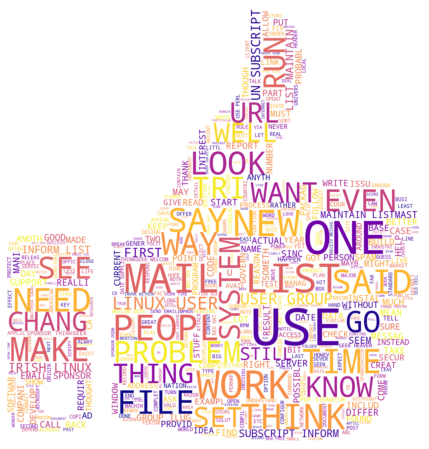

In [34]:
# Display wordcloud for non spam messages

icon = Image.open(THUMBS_UP_SHAPE)
image_canvas = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_canvas.paste(icon, box=icon)

rgb_array = np.array(image_canvas)

ready_non_spam = ' '.join(flat_list_non_spam)

word_cloud_3 = WordCloud(mask=rgb_array,background_color='white',colormap='plasma',max_words=500)

word_cloud_3.generate(ready_non_spam.upper())
plt.figure(figsize=[16,8])
plt.imshow(word_cloud_3, interpolation='bilinear')
plt.axis('off')
plt.show()

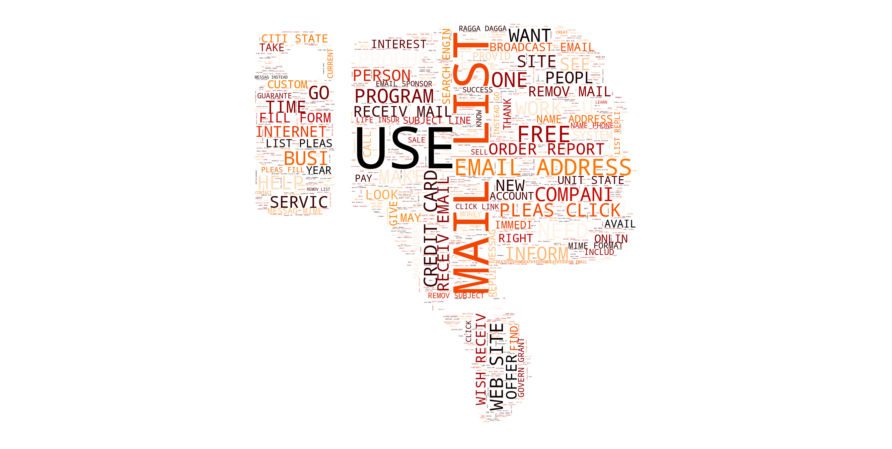

In [35]:
# Display wordcloud for non spam messages

icon = Image.open(THUMBS_DOWN_SHAPE)
image_canvas = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_canvas.paste(icon, box=icon)

rgb_array = np.array(image_canvas)

ready_spam = ' '.join(flat_list_spam)

word_cloud_4 = WordCloud(mask=rgb_array,background_color='white',colormap='gist_heat',max_words=1000)

word_cloud_4.generate(ready_spam.upper())
plt.figure(figsize=[16,8])
plt.imshow(word_cloud_4, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary

In [36]:
# Select a subset of words to create a vocabulary

vocabulary_subset = email_collection.MESSAGE.apply(pre_process_email)
flat_vocabulary_list = [item for sublist in vocabulary_subset for item in sublist]

In [37]:
# Create a series of unique words

unique_words = pd.Series(flat_vocabulary_list).value_counts()

# Get the most frequent 2500 words,
# this are going to be used to train the ML algorithm
ml_training_list = unique_words[VOCABULARY_START:VOCABULARY_LIMIT]

In [38]:
# Create IDs for the subset of emails and create the dataframe

unique_word_ids = range(VOCABULARY_START, VOCABULARY_LIMIT)
unique_dataframe = pd.DataFrame({'VOCABULARY_WORD': ml_training_list.index.values}, index=unique_word_ids)
unique_dataframe.index.name = 'WORD_ID'

In [39]:
# Save vocabulary as CSV

unique_dataframe.to_csv(WORD_ID_FILE, index_label=unique_dataframe.index.name, header=unique_dataframe.VOCABULARY_WORD.name)

# Generate Sparse Matrix and Features

In [40]:
# Create a dataframe, one word per column.
word_matrix_df = pd.DataFrame.from_records(processed_emails.tolist())

# Spliting data into Training and Testing dataset

In [41]:
x_train, x_test, y_train, y_test = train_test_split(word_matrix_df, email_collection.CATEGORY, test_size=0.3, random_state=42)
x_train.index.name = x_test.index.name = 'DOC_ID'

In [42]:
# Show some of the results

print('Number of training samples', x_train.shape[0] )
print('Fraction of training set', x_train.shape[0] / word_matrix_df.shape[0] )

Number of training samples 4057
Fraction of training set 0.6999654934437544


In [43]:
word_index = pd.Index(unique_dataframe.VOCABULARY_WORD)

In [44]:
# Creation of a Sparse matrix

def create_sparse_mtx(df, idx_words, labels):
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(idx_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            word = df.iat[i,j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = idx_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,'OCCURENCE': 1, 'WORD_ID': word_id}
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [45]:
%%time
# Above check the time that it takes to run the function for research and performance purposes.
# Running the function to create the  training sparse matrix.

training_sparse_mtx = create_sparse_mtx(x_train, word_index, y_train)

Wall time: 3min 18s


In [46]:
%%time
# Above check the time that it takes to run the function for research and performance purposes.
# Running the function to create the  testing sparse matrix.

testing_sparse_mtx = create_sparse_mtx(x_test, word_index, y_test)

Wall time: 1min 12s


In [47]:
# This is how it looks after creating the training matrix
training_sparse_mtx[:5]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,266
1,0,4844,1,1267
2,0,4844,1,508
3,0,4844,1,310
4,0,4844,1,255


In [48]:
# This function will use the pandas groupby method to combine ocurrences
# the result will be a much lighter version of the full sparse matrix
def create_mtx_light(mtx, columns):
    no_occurences = mtx.groupby(columns).sum()
    no_occurences = no_occurences.reset_index()
    
    return no_occurences

In [49]:
# Call the "create_mtx_light" function to create a light matrix for training and testing data.

train_no_occurences = create_mtx_light(training_sparse_mtx, SPARSE_COLUMNS)
test_no_occurences = create_mtx_light(testing_sparse_mtx, SPARSE_COLUMNS)

In [50]:
# How it looks after combining occurences
train_no_occurences.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [51]:
# By using the groupby function we have dramatically decrease the ammount of rows in our train dataset.
print('DataFrame with repetitions: ', training_sparse_mtx.shape)
print('DataFrame without repetitions: ', train_no_occurences.shape)

DataFrame with repetitions:  (431002, 4)
DataFrame without repetitions:  (258304, 4)


### Save training & testing datasets as text files.

In [52]:
np.savetxt(TRAINING_FILE, train_no_occurences, fmt='%d')

In [53]:
np.savetxt(TESTING_FILE, test_no_occurences, fmt='%d')